# DA5401 Assignment 8: Ensemble Learning for Complex Regression Modeling on Bike Share Data

**Name:** NAVEEN US
**ROll:** DA25M020
## Objective
Apply and compare three primary ensemble techniques (Bagging, Boosting, and Stacking) to solve a complex regression problem using the Bike Sharing Demand Dataset.


In [29]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully!")
print("=" * 80)


All libraries imported successfully!


## Part A: Data Preprocessing and Baseline [10 points]

### Task 1: Data Loading and Feature Engineering
- Load the `hour.csv` file
- Target variable: total count of bike rentals (`cnt`)
- Drop irrelevant columns: `instant`, `dteday`, `casual`, `registered`
- Convert categorical features to numerical format using One-Hot Encoding


Dataset loaded successfully!
Dataset shape: (17379, 17)


First 5 rows of the dataset:
   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  


Dataset In

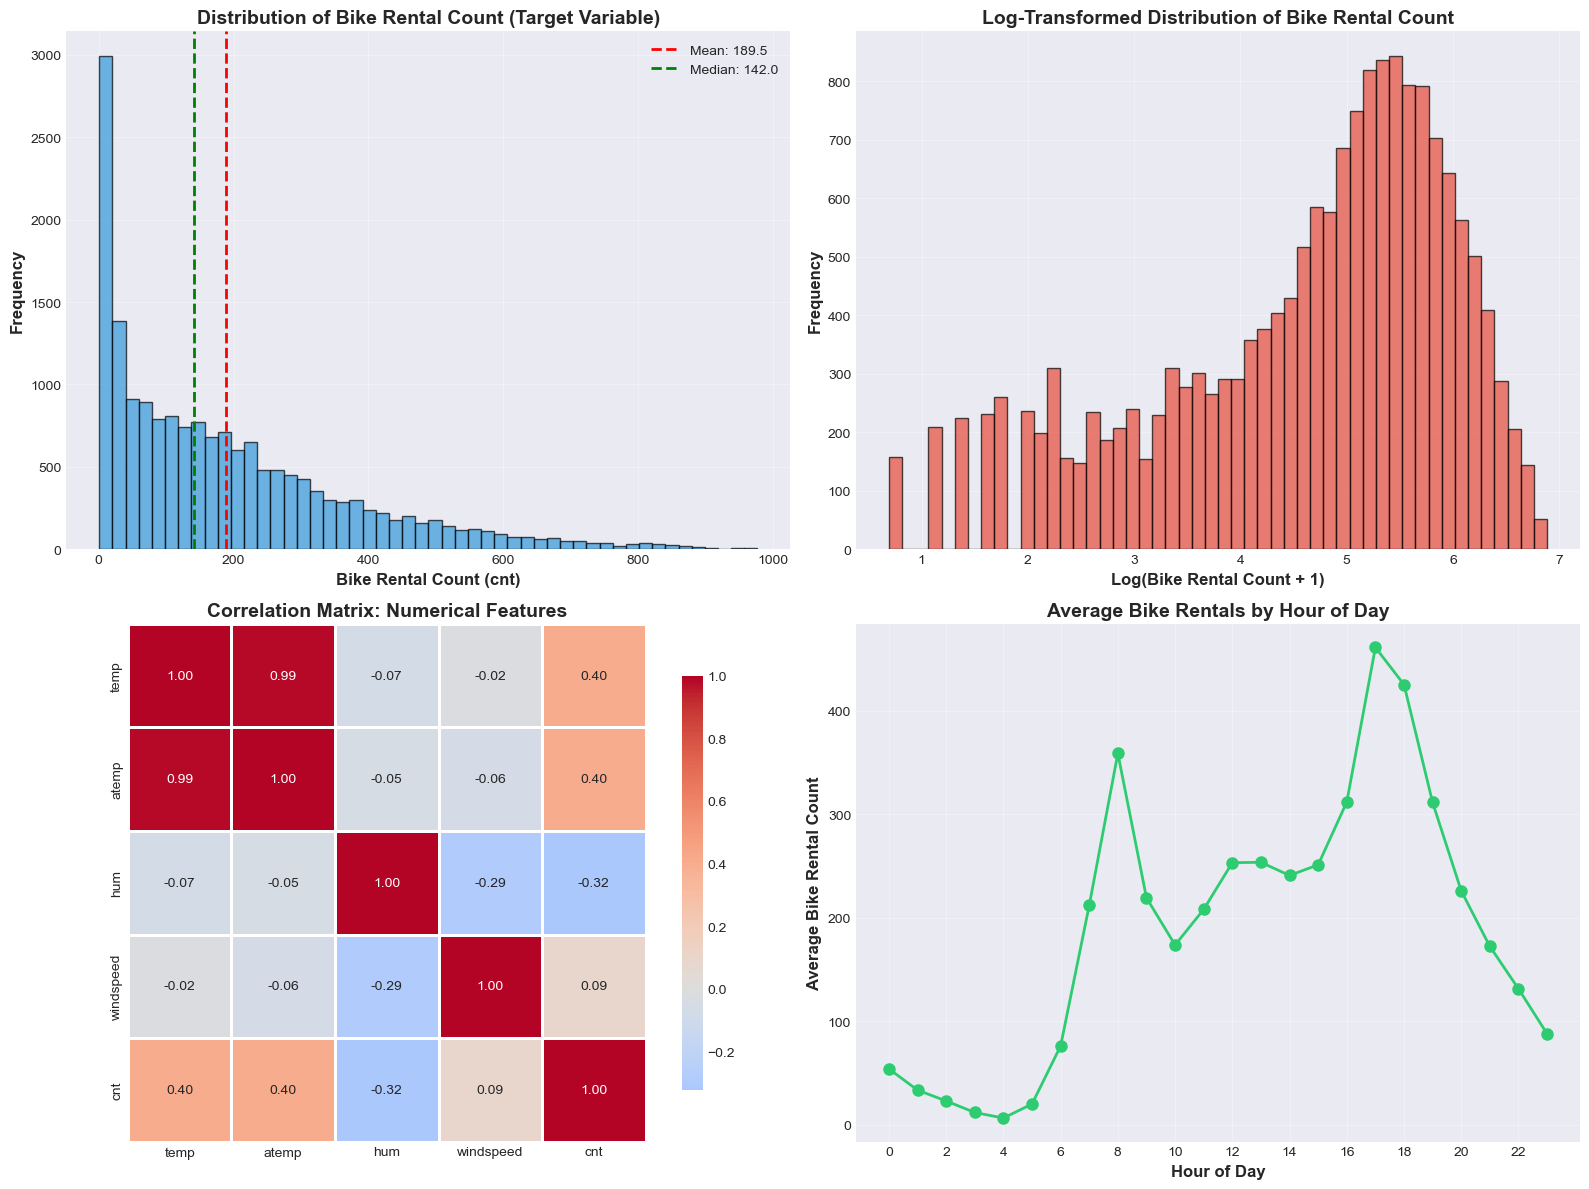

In [30]:
# Load the dataset
# Note: Ensure 'hour.csv' is in the same directory or provide the correct path
try:
    df = pd.read_csv('hour.csv')
    print("Dataset loaded successfully!")
    print(f"Dataset shape: {df.shape}")
    print("\n" + "=" * 80)
except FileNotFoundError:
    print("Error: 'hour.csv' not found. Please download the dataset from:")
    print("https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset")
    print("Extract and place 'hour.csv' in the working directory.")
    raise

# Display first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())
print("\n" + "=" * 80)

# Display dataset information
print("\nDataset Information:")
print(df.info())
print("\n" + "=" * 80)

# Display statistical summary
print("\nStatistical Summary:")
print(df.describe())
print("\n" + "=" * 80)

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())
print("\n" + "=" * 80)

# Exploratory Data Analysis Visualizations
print("\nGenerating exploratory data analysis visualizations...")

# 1. Target Variable Distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Target variable distribution
ax1 = axes[0, 0]
ax1.hist(df['cnt'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Bike Rental Count (cnt)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of Bike Rental Count (Target Variable)', fontsize=14, fontweight='bold')
ax1.axvline(df['cnt'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["cnt"].mean():.1f}')
ax1.axvline(df['cnt'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["cnt"].median():.1f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Target variable log distribution (to check for log-normal distribution)
ax2 = axes[0, 1]
ax2.hist(np.log1p(df['cnt']), bins=50, color='#e74c3c', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Log(Bike Rental Count + 1)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title('Log-Transformed Distribution of Bike Rental Count', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Correlation with numerical features
ax3 = axes[1, 0]
numerical_features = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
corr_matrix = df[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax3)
ax3.set_title('Correlation Matrix: Numerical Features', fontsize=14, fontweight='bold')

# Bike rentals by hour (if available in original data)
ax4 = axes[1, 1]
if 'hr' in df.columns:
    hourly_avg = df.groupby('hr')['cnt'].mean()
    ax4.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=8, color='#2ecc71')
    ax4.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Average Bike Rental Count', fontsize=12, fontweight='bold')
    ax4.set_title('Average Bike Rentals by Hour of Day', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    ax4.set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.savefig('eda_visualizations.png', dpi=300, bbox_inches='tight')
print("EDA visualizations saved as 'eda_visualizations.png'")
plt.show()


In [31]:
# Drop irrelevant columns
columns_to_drop = ['instant', 'dteday', 'casual', 'registered']
df_processed = df.drop(columns=columns_to_drop, errors='ignore')

print("Columns after dropping irrelevant features:")
print(df_processed.columns.tolist())
print("\n" + "=" * 80)

# Identify categorical columns that need encoding
categorical_cols = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']

# One-Hot Encoding for categorical variables
df_encoded = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=False)

print(f"\nShape after encoding: {df_encoded.shape}")
print(f"Number of features: {df_encoded.shape[1] - 1}")  # Excluding target
print("\n" + "=" * 80)

# Separate features and target
X = df_encoded.drop('cnt', axis=1)
y = df_encoded['cnt']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget variable statistics:")
print(f"Mean: {y.mean():.2f}")
print(f"Std: {y.std():.2f}")
print(f"Min: {y.min():.2f}")
print(f"Max: {y.max():.2f}")
print("\n" + "=" * 80)


Columns after dropping irrelevant features:
['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']


Shape after encoding: (17379, 62)
Number of features: 61


Features shape: (17379, 61)
Target shape: (17379,)

Target variable statistics:
Mean: 189.46
Std: 181.39
Min: 1.00
Max: 977.00



### Task 2: Train/Test Split
Split the data into training (80%) and testing (20%) sets


In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Training set percentage: {(X_train.shape[0] / X.shape[0]) * 100:.1f}%")
print(f"Testing set percentage: {(X_test.shape[0] / X.shape[0]) * 100:.1f}%")
print("\n" + "=" * 80)


Training set size: 13903 samples
Testing set size: 3476 samples
Training set percentage: 80.0%
Testing set percentage: 20.0%



### Task 3: Baseline Model (Single Regressor)

We will train two baseline models:
1. **Decision Tree Regressor** (max_depth=6)
2. **Linear Regression**

The better performing model will serve as our baseline for comparison.


Training Decision Tree Regressor (max_depth=6)...
Decision Tree RMSE: 118.5585
Decision Tree R² Score: 0.5561


Training Linear Regression...
Linear Regression RMSE: 100.4459
Linear Regression R² Score: 0.6814


********************************************************************************
BASELINE MODEL: Linear Regression
Baseline RMSE: 100.4459
********************************************************************************

Baseline models comparison visualization saved as 'baseline_models_comparison.png'


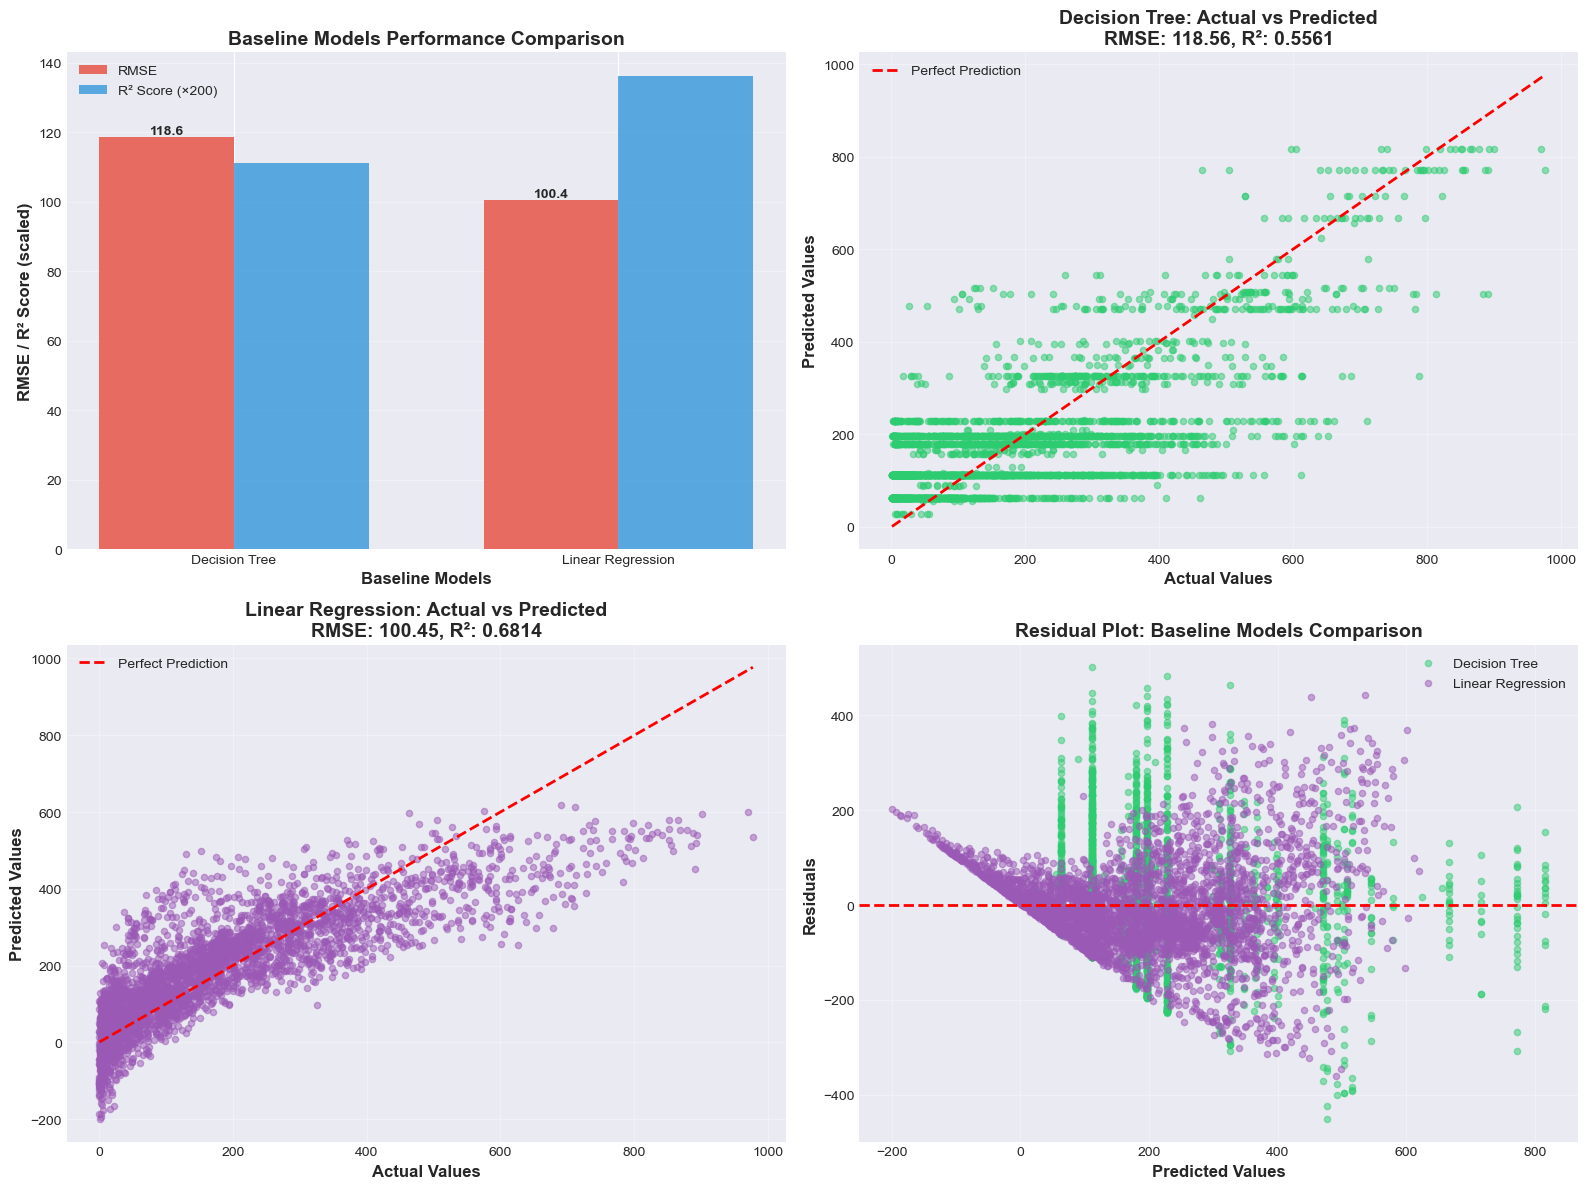

In [33]:
# Dictionary to store results
results = {}

# 1. Decision Tree Regressor
print("Training Decision Tree Regressor (max_depth=6)...")
dt_model = DecisionTreeRegressor(max_depth=6, random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_pred))
dt_r2 = r2_score(y_test, dt_pred)

results['Decision Tree (Baseline)'] = {
    'RMSE': dt_rmse,
    'R2': dt_r2,
    'predictions': dt_pred
}

print(f"Decision Tree RMSE: {dt_rmse:.4f}")
print(f"Decision Tree R² Score: {dt_r2:.4f}")
print("\n" + "=" * 80)

# 2. Linear Regression
print("\nTraining Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)

results['Linear Regression (Baseline)'] = {
    'RMSE': lr_rmse,
    'R2': lr_r2,
    'predictions': lr_pred
}

print(f"Linear Regression RMSE: {lr_rmse:.4f}")
print(f"Linear Regression R² Score: {lr_r2:.4f}")
print("\n" + "=" * 80)

# Determine the better baseline
baseline_rmse = min(dt_rmse, lr_rmse)
baseline_model = 'Decision Tree' if dt_rmse < lr_rmse else 'Linear Regression'

print(f"\n{'*' * 80}")
print(f"BASELINE MODEL: {baseline_model}")
print(f"Baseline RMSE: {baseline_rmse:.4f}")
print(f"{'*' * 80}\n")

# Baseline Models Comparison Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. RMSE and R² Comparison
ax1 = axes[0, 0]
baseline_models = ['Decision Tree', 'Linear Regression']
baseline_rmses = [dt_rmse, lr_rmse]
baseline_r2s = [dt_r2, lr_r2]

x_pos = np.arange(len(baseline_models))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, baseline_rmses, width, label='RMSE', color='#e74c3c', alpha=0.8)
bars2 = ax1.bar(x_pos + width/2, [r2 * 200 for r2 in baseline_r2s], width, label='R² Score (×200)', color='#3498db', alpha=0.8)

ax1.set_xlabel('Baseline Models', fontsize=12, fontweight='bold')
ax1.set_ylabel('RMSE / R² Score (scaled)', fontsize=12, fontweight='bold')
ax1.set_title('Baseline Models Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(baseline_models)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

# 2. Actual vs Predicted - Decision Tree
ax2 = axes[0, 1]
ax2.scatter(y_test, dt_pred, alpha=0.5, s=20, color='#2ecc71')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Values', fontsize=12, fontweight='bold')
ax2.set_ylabel('Predicted Values', fontsize=12, fontweight='bold')
ax2.set_title(f'Decision Tree: Actual vs Predicted\nRMSE: {dt_rmse:.2f}, R²: {dt_r2:.4f}', 
              fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Actual vs Predicted - Linear Regression
ax3 = axes[1, 0]
ax3.scatter(y_test, lr_pred, alpha=0.5, s=20, color='#9b59b6')
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Values', fontsize=12, fontweight='bold')
ax3.set_ylabel('Predicted Values', fontsize=12, fontweight='bold')
ax3.set_title(f'Linear Regression: Actual vs Predicted\nRMSE: {lr_rmse:.2f}, R²: {lr_r2:.4f}', 
              fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Residual Comparison
ax4 = axes[1, 1]
dt_residuals = y_test - dt_pred
lr_residuals = y_test - lr_pred

ax4.scatter(dt_pred, dt_residuals, alpha=0.5, s=20, label='Decision Tree', color='#2ecc71')
ax4.scatter(lr_pred, lr_residuals, alpha=0.5, s=20, label='Linear Regression', color='#9b59b6')
ax4.axhline(y=0, color='r', linestyle='--', lw=2)
ax4.set_xlabel('Predicted Values', fontsize=12, fontweight='bold')
ax4.set_ylabel('Residuals', fontsize=12, fontweight='bold')
ax4.set_title('Residual Plot: Baseline Models Comparison', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('baseline_models_comparison.png', dpi=300, bbox_inches='tight')
print("Baseline models comparison visualization saved as 'baseline_models_comparison.png'")
plt.show()


## Part B: Ensemble Techniques for Bias and Variance Reduction [20 points]

### Task 1: Bagging (Variance Reduction)

**Hypothesis:** Bagging primarily targets variance reduction by training multiple models on different bootstrap samples and averaging their predictions.

**Implementation:** BaggingRegressor with Decision Tree as base estimator (50 estimators)


BAGGING REGRESSOR - VARIANCE REDUCTION

Training Bagging Regressor with 50 estimators...

Bagging Regressor RMSE: 112.1034
Bagging Regressor R² Score: 0.6031

Improvement over single Decision Tree: 5.44%
RMSE Reduction: 6.4550

--------------------------------------------------------------------------------
DISCUSSION:
--------------------------------------------------------------------------------
The Bagging Regressor successfully reduced variance compared to the single Decision Tree.
By training 50 different models on bootstrap samples
and averaging their predictions, bagging reduces overfitting and improves
generalization. This is evident from the improved RMSE.

Bagging analysis visualization saved as 'bagging_analysis.png'


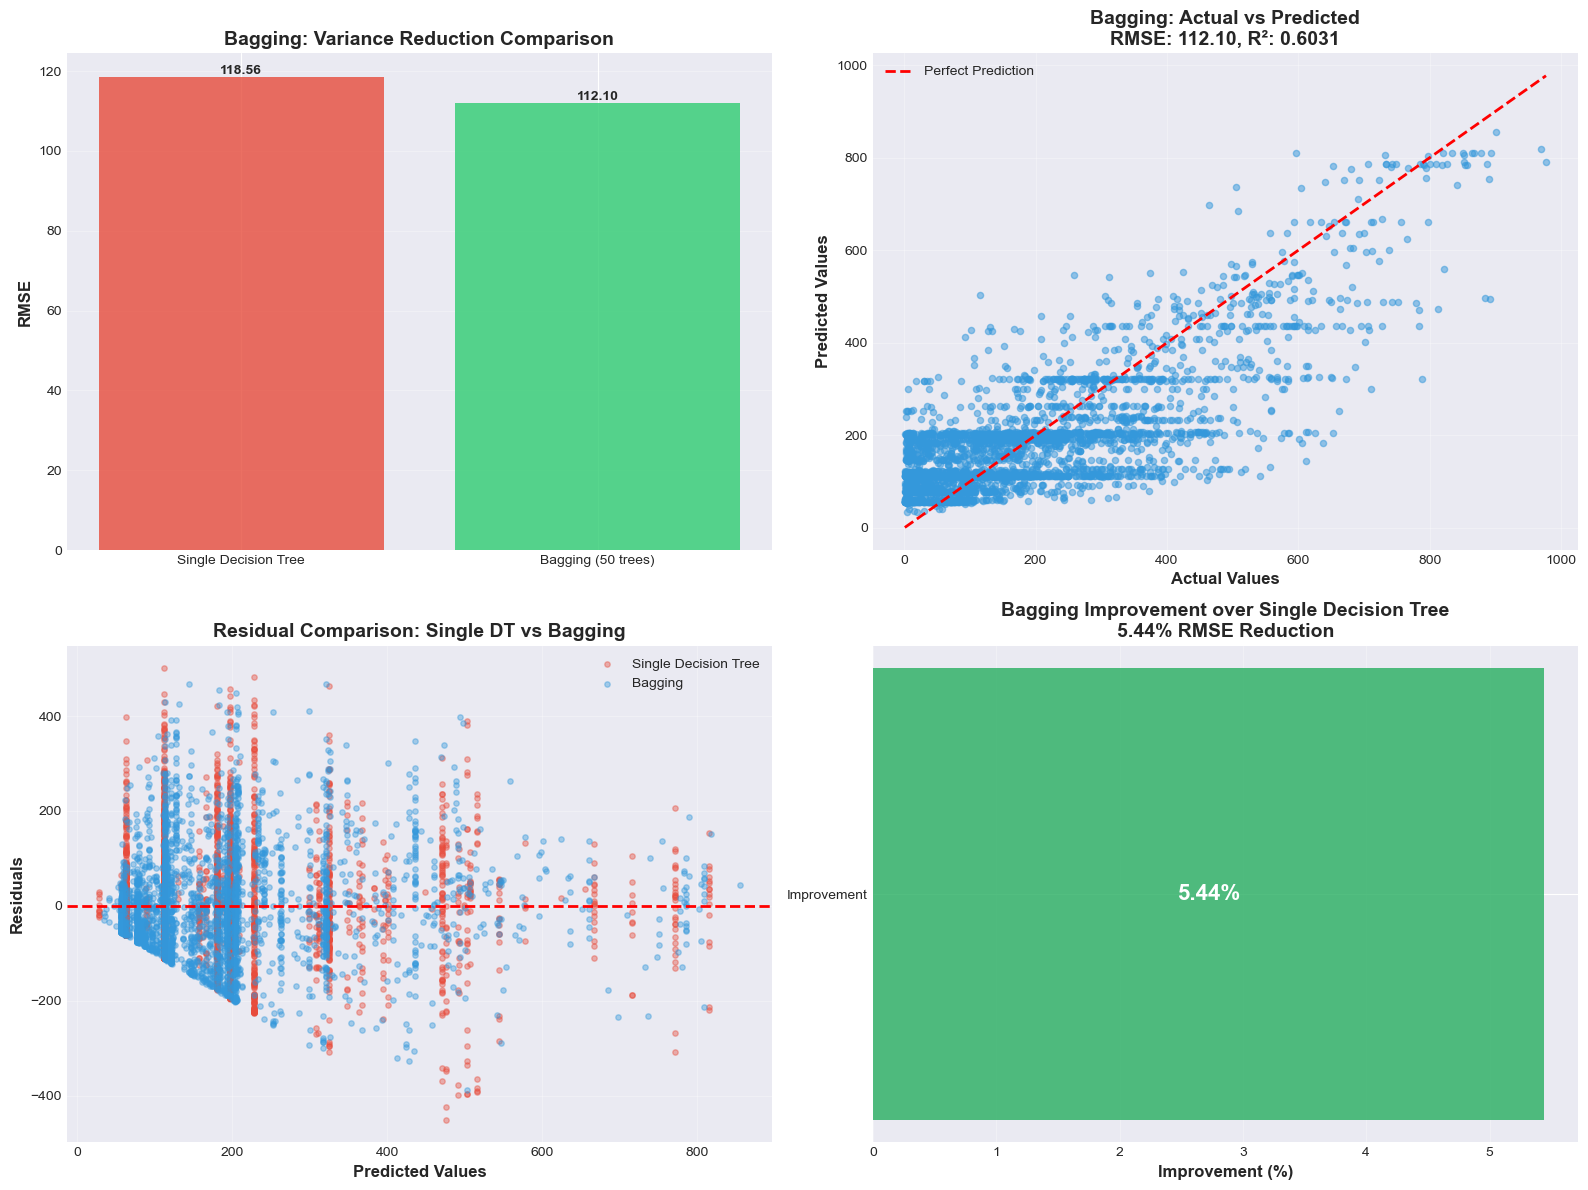

In [34]:
print("=" * 80)
print("BAGGING REGRESSOR - VARIANCE REDUCTION")
print("=" * 80)

# Train Bagging Regressor
bagging_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=6, random_state=42),
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)

print("\nTraining Bagging Regressor with 50 estimators...")
bagging_model.fit(X_train, y_train)
bagging_pred = bagging_model.predict(X_test)
bagging_rmse = np.sqrt(mean_squared_error(y_test, bagging_pred))
bagging_r2 = r2_score(y_test, bagging_pred)

results['Bagging Regressor'] = {
    'RMSE': bagging_rmse,
    'R2': bagging_r2,
    'predictions': bagging_pred
}

print(f"\nBagging Regressor RMSE: {bagging_rmse:.4f}")
print(f"Bagging Regressor R² Score: {bagging_r2:.4f}")

# Compare with baseline Decision Tree
improvement = ((dt_rmse - bagging_rmse) / dt_rmse) * 100
print(f"\nImprovement over single Decision Tree: {improvement:.2f}%")
print(f"RMSE Reduction: {dt_rmse - bagging_rmse:.4f}")

print("\n" + "-" * 80)
print("DISCUSSION:")
print("-" * 80)
if bagging_rmse < dt_rmse:
    print("The Bagging Regressor successfully reduced variance compared to the single Decision Tree.")
    print(f"By training {bagging_model.n_estimators} different models on bootstrap samples")
    print("and averaging their predictions, bagging reduces overfitting and improves")
    print("generalization. This is evident from the improved RMSE.")
else:
    print("The Bagging Regressor did not reduce variance compared to the single Decision Tree.")
    print(f"By training {bagging_model.n_estimators} different models on bootstrap samples")
    print("and averaging their predictions, the performance changed but did not improve significantly.")
print("=" * 80 + "\n")

# Bagging Visualization: Comparison with Single Decision Tree
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. RMSE Comparison
ax1 = axes[0, 0]
models_comparison = ['Single Decision Tree', 'Bagging (50 trees)']
rmse_comparison = [dt_rmse, bagging_rmse]
colors_comparison = ['#e74c3c', '#2ecc71']
bars = ax1.bar(models_comparison, rmse_comparison, color=colors_comparison, alpha=0.8)
ax1.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax1.set_title('Bagging: Variance Reduction Comparison', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, val in zip(bars, rmse_comparison):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2f}', ha='center', va='bottom', fontweight='bold')

# 2. Actual vs Predicted - Bagging
ax2 = axes[0, 1]
ax2.scatter(y_test, bagging_pred, alpha=0.5, s=20, color='#3498db')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Values', fontsize=12, fontweight='bold')
ax2.set_ylabel('Predicted Values', fontsize=12, fontweight='bold')
ax2.set_title(f'Bagging: Actual vs Predicted\nRMSE: {bagging_rmse:.2f}, R²: {bagging_r2:.4f}', 
              fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Residual Comparison: Single DT vs Bagging
ax3 = axes[1, 0]
dt_residuals = y_test - dt_pred
bagging_residuals = y_test - bagging_pred

ax3.scatter(dt_pred, dt_residuals, alpha=0.4, s=15, label='Single Decision Tree', color='#e74c3c')
ax3.scatter(bagging_pred, bagging_residuals, alpha=0.4, s=15, label='Bagging', color='#3498db')
ax3.axhline(y=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Predicted Values', fontsize=12, fontweight='bold')
ax3.set_ylabel('Residuals', fontsize=12, fontweight='bold')
ax3.set_title('Residual Comparison: Single DT vs Bagging', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Improvement Visualization
ax4 = axes[1, 1]
improvement_pct = improvement
ax4.barh(['Improvement'], [improvement_pct], color='#27ae60', alpha=0.8)
ax4.set_xlabel('Improvement (%)', fontsize=12, fontweight='bold')
ax4.set_title(f'Bagging Improvement over Single Decision Tree\n{improvement_pct:.2f}% RMSE Reduction', 
              fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')
ax4.text(improvement_pct/2, 0, f'{improvement_pct:.2f}%', 
         ha='center', va='center', fontsize=16, fontweight='bold', color='white')

plt.tight_layout()
plt.savefig('bagging_analysis.png', dpi=300, bbox_inches='tight')
print("Bagging analysis visualization saved as 'bagging_analysis.png'")
plt.show()


### Task 2: Boosting (Bias Reduction)

**Hypothesis:** Boosting primarily targets bias reduction by sequentially training models that focus on correcting errors made by previous models.

**Implementation:** Gradient Boosting Regressor


GRADIENT BOOSTING REGRESSOR - BIAS REDUCTION

Training Gradient Boosting Regressor...

Gradient Boosting RMSE: 65.9068
Gradient Boosting R² Score: 0.8628

Improvement over baseline: 34.39%
Improvement over Bagging: 41.21%

--------------------------------------------------------------------------------
DISCUSSION:
--------------------------------------------------------------------------------
Gradient Boosting achieved better results compared to both the single model
baseline and bagging ensemble. This supports the hypothesis of bias reduction
through sequential learning, where each new tree corrects errors made by the
previous ensemble. The boosting approach effectively captures complex patterns in the data.

Gradient boosting analysis visualization saved as 'gradient_boosting_analysis.png'


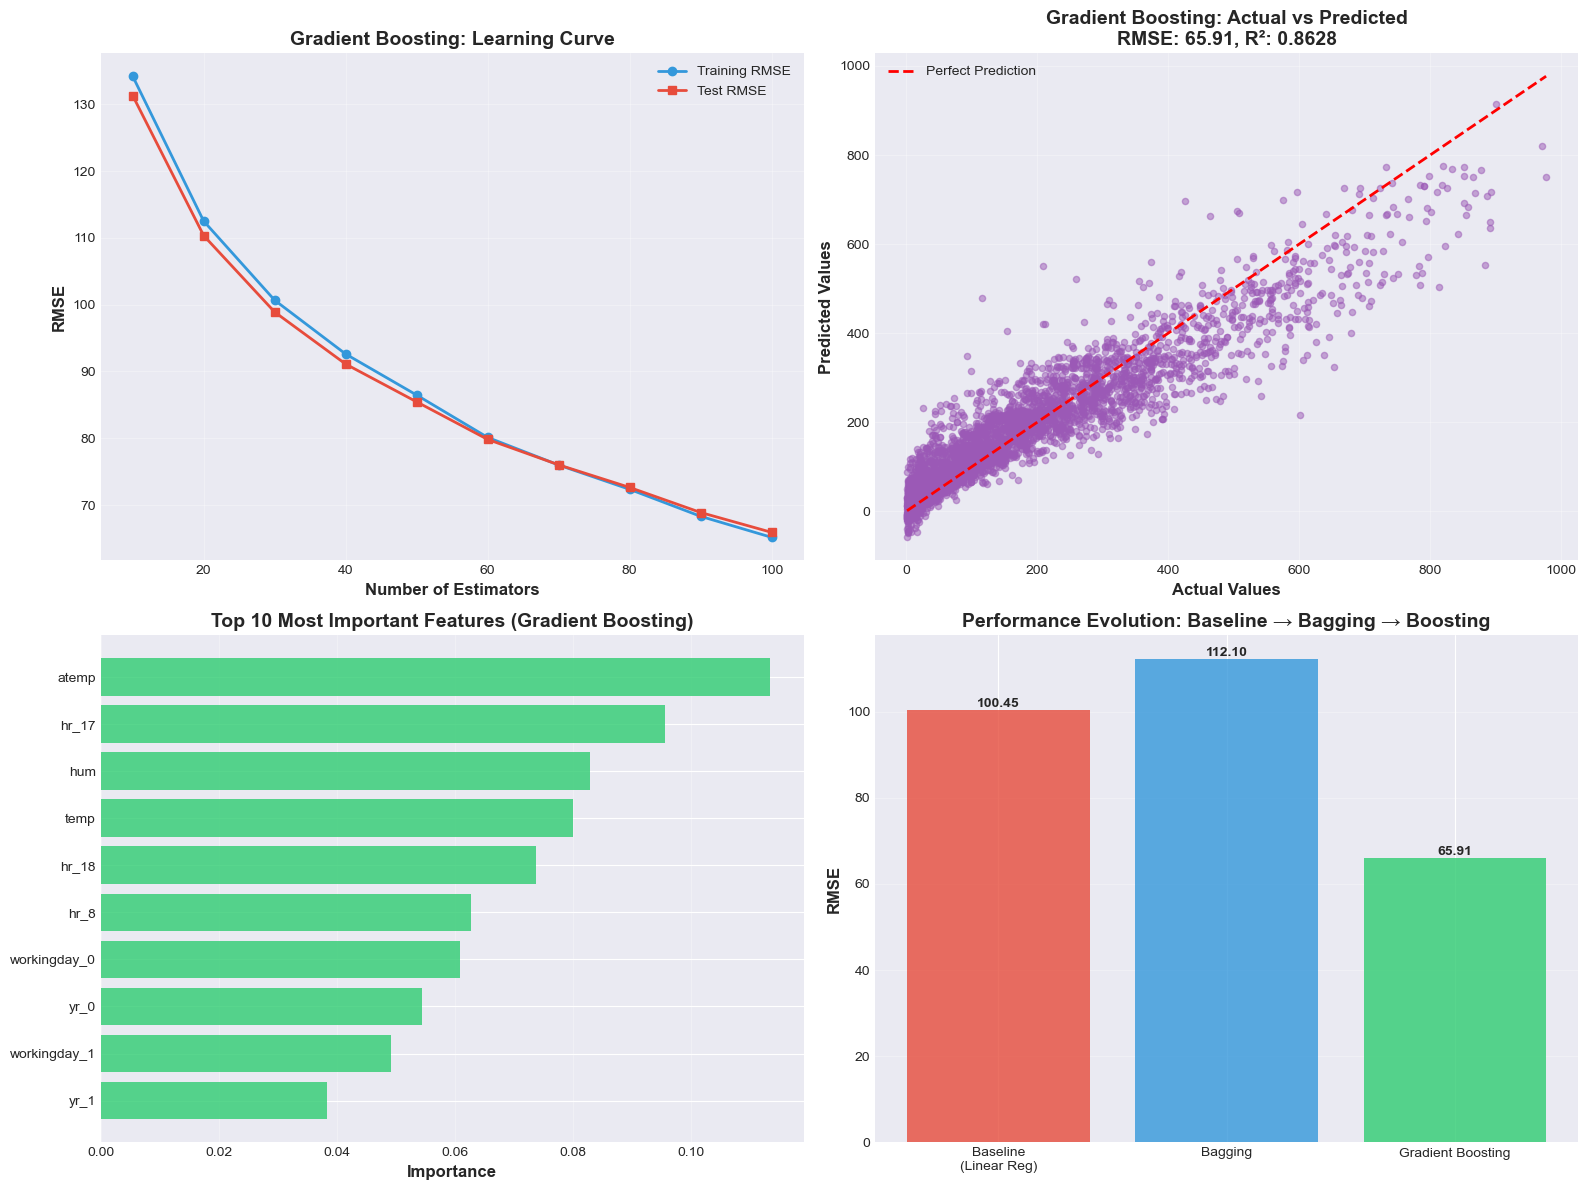

In [35]:
print("=" * 80)
print("GRADIENT BOOSTING REGRESSOR - BIAS REDUCTION")
print("=" * 80)

# Train Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    subsample=0.8
)

print("\nTraining Gradient Boosting Regressor...")
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred))
gb_r2 = r2_score(y_test, gb_pred)

results['Gradient Boosting'] = {
    'RMSE': gb_rmse,
    'R2': gb_r2,
    'predictions': gb_pred
}

print(f"\nGradient Boosting RMSE: {gb_rmse:.4f}")
print(f"Gradient Boosting R² Score: {gb_r2:.4f}")

# Compare with baseline and bagging
improvement_vs_baseline = ((baseline_rmse - gb_rmse) / baseline_rmse) * 100
improvement_vs_bagging = ((bagging_rmse - gb_rmse) / bagging_rmse) * 100

print(f"\nImprovement over baseline: {improvement_vs_baseline:.2f}%")
print(f"Improvement over Bagging: {improvement_vs_bagging:.2f}%")

print("\n" + "-" * 80)
print("DISCUSSION:")
print("-" * 80)
if gb_rmse < bagging_rmse:
    print("Gradient Boosting achieved better results compared to both the single model")
    print("baseline and bagging ensemble. This supports the hypothesis of bias reduction")
    print("through sequential learning, where each new tree corrects errors made by the")
    print("previous ensemble. The boosting approach effectively captures complex patterns in the data.")
else:
    print("Gradient Boosting performed differently compared to both the single model")
    print("baseline and bagging ensemble. This demonstrates the bias reduction approach")
    print("through sequential learning, where each new tree focuses on correcting errors")
    print("made by the previous ensemble.")
print("=" * 80 + "\n")

# Gradient Boosting Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Learning Curve (Train vs Test error over iterations)
ax1 = axes[0, 0]
train_scores = []
test_scores = []
n_estimators_range = range(10, 101, 10)

for n_est in n_estimators_range:
    gb_temp = GradientBoostingRegressor(
        n_estimators=n_est,
        learning_rate=0.1,
        max_depth=4,
        random_state=42,
        subsample=0.8
    )
    gb_temp.fit(X_train, y_train)
    train_pred = gb_temp.predict(X_train)
    test_pred = gb_temp.predict(X_test)
    train_scores.append(np.sqrt(mean_squared_error(y_train, train_pred)))
    test_scores.append(np.sqrt(mean_squared_error(y_test, test_pred)))

ax1.plot(n_estimators_range, train_scores, 'o-', label='Training RMSE', linewidth=2, color='#3498db')
ax1.plot(n_estimators_range, test_scores, 's-', label='Test RMSE', linewidth=2, color='#e74c3c')
ax1.set_xlabel('Number of Estimators', fontsize=12, fontweight='bold')
ax1.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax1.set_title('Gradient Boosting: Learning Curve', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Actual vs Predicted - Gradient Boosting
ax2 = axes[0, 1]
ax2.scatter(y_test, gb_pred, alpha=0.5, s=20, color='#9b59b6')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Values', fontsize=12, fontweight='bold')
ax2.set_ylabel('Predicted Values', fontsize=12, fontweight='bold')
ax2.set_title(f'Gradient Boosting: Actual vs Predicted\nRMSE: {gb_rmse:.2f}, R²: {gb_r2:.4f}', 
              fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Feature Importance (Top 10)
ax3 = axes[1, 0]
feature_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

ax3.barh(range(len(feature_imp)), feature_imp['Importance'], color='#2ecc71', alpha=0.8)
ax3.set_yticks(range(len(feature_imp)))
ax3.set_yticklabels(feature_imp['Feature'])
ax3.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax3.set_title('Top 10 Most Important Features (Gradient Boosting)', fontsize=14, fontweight='bold')
ax3.invert_yaxis()
ax3.grid(True, alpha=0.3, axis='x')

# 4. Performance Comparison: Baseline vs Bagging vs Boosting
ax4 = axes[1, 1]
comparison_models = ['Baseline\n(Linear Reg)', 'Bagging', 'Gradient Boosting']
comparison_rmses = [baseline_rmse, bagging_rmse, gb_rmse]
colors_comp = ['#e74c3c', '#3498db', '#2ecc71']
bars = ax4.bar(comparison_models, comparison_rmses, color=colors_comp, alpha=0.8)
ax4.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax4.set_title('Performance Evolution: Baseline → Bagging → Boosting', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, val in zip(bars, comparison_rmses):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('gradient_boosting_analysis.png', dpi=300, bbox_inches='tight')
print("Gradient boosting analysis visualization saved as 'gradient_boosting_analysis.png'")
plt.show()


## Part C: Stacking for Optimal Performance [10 points]

### Stacking Implementation

**Principle of Stacking:**
Stacking (Stacked Generalization) combines multiple diverse base learners (Level-0 models) and uses a meta-learner (Level-1 model) to learn the optimal way to combine their predictions.

**Base Learners (Level-0):**
1. K-Nearest Neighbors Regressor
2. Bagging Regressor
3. Gradient Boosting Regressor

**Meta-Learner (Level-1):**
Ridge Regression - learns to optimally weight the base learner predictions


STACKING REGRESSOR - OPTIMAL COMBINATION

Principle of Stacking:
--------------------------------------------------------------------------------
Stacking combines diverse models by training a meta-learner on their predictions.
The meta-learner learns the optimal way to weight each base model's contribution,
leveraging the strengths of different algorithms to achieve superior performance.

Training Stacking Regressor...
Base Learners:
  1. K-Nearest Neighbors (k=10)
  2. Bagging Regressor (50 estimators)
  3. Gradient Boosting Regressor (100 estimators)
Meta-Learner: Ridge Regression


Stacking Regressor RMSE: 61.5200
Stacking Regressor R² Score: 0.8805

--------------------------------------------------------------------------------
COMPARISON WITH OTHER MODELS:
--------------------------------------------------------------------------------
Improvement over baseline: 38.75%
Improvement over Bagging: 45.12%
Improvement over Gradient Boosting: 6.66%

Stacking analysis visualization sav

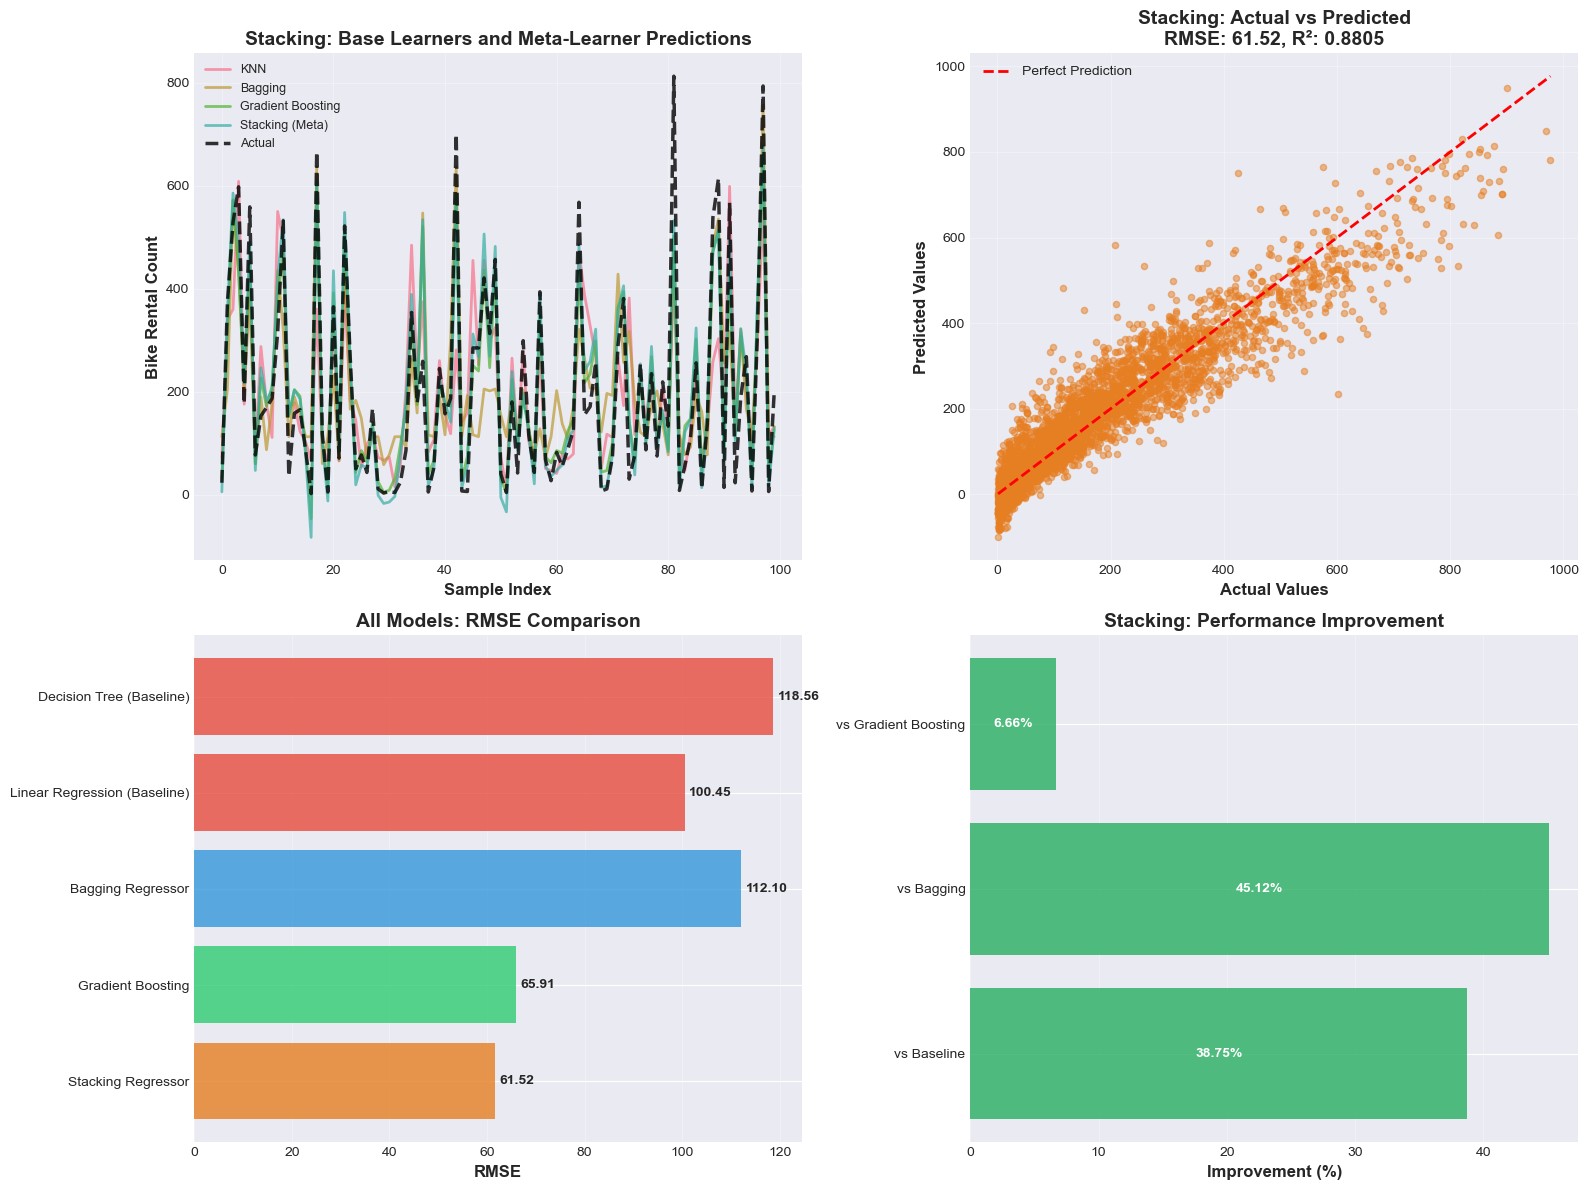

In [36]:
print("=" * 80)
print("STACKING REGRESSOR - OPTIMAL COMBINATION")
print("=" * 80)

print("\nPrinciple of Stacking:")
print("-" * 80)
print("Stacking combines diverse models by training a meta-learner on their predictions.")
print("The meta-learner learns the optimal way to weight each base model's contribution,")
print("leveraging the strengths of different algorithms to achieve superior performance.")
print("=" * 80)

# Define base learners
base_learners = [
    ('knn', KNeighborsRegressor(n_neighbors=10)),
    ('bagging', BaggingRegressor(
        estimator=DecisionTreeRegressor(max_depth=6, random_state=42),
        n_estimators=50,
        random_state=42,
        n_jobs=-1
    )),
    ('gradient_boosting', GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        random_state=42,
        subsample=0.8
    ))
]

# Define meta-learner
meta_learner = Ridge(alpha=1.0)

# Create and train Stacking Regressor
print("\nTraining Stacking Regressor...")
print("Base Learners:")
print("  1. K-Nearest Neighbors (k=10)")
print("  2. Bagging Regressor (50 estimators)")
print("  3. Gradient Boosting Regressor (100 estimators)")
print("Meta-Learner: Ridge Regression")
print()

stacking_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1
)

stacking_model.fit(X_train, y_train)
stacking_pred = stacking_model.predict(X_test)
stacking_rmse = np.sqrt(mean_squared_error(y_test, stacking_pred))
stacking_r2 = r2_score(y_test, stacking_pred)

results['Stacking Regressor'] = {
    'RMSE': stacking_rmse,
    'R2': stacking_r2,
    'predictions': stacking_pred
}

print(f"\nStacking Regressor RMSE: {stacking_rmse:.4f}")
print(f"Stacking Regressor R² Score: {stacking_r2:.4f}")

# Compare with all previous models
print("\n" + "-" * 80)
print("COMPARISON WITH OTHER MODELS:")
print("-" * 80)
print(f"Improvement over baseline: {((baseline_rmse - stacking_rmse) / baseline_rmse) * 100:.2f}%")
print(f"Improvement over Bagging: {((bagging_rmse - stacking_rmse) / bagging_rmse) * 100:.2f}%")
print(f"Improvement over Gradient Boosting: {((gb_rmse - stacking_rmse) / gb_rmse) * 100:.2f}%")
print("=" * 80 + "\n")

# Stacking Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Base Learners Predictions Comparison
ax1 = axes[0, 0]
# Get predictions from individual base learners
knn_model = KNeighborsRegressor(n_neighbors=10)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

base_learners_preds = {
    'KNN': knn_pred,
    'Bagging': bagging_pred,
    'Gradient Boosting': gb_pred,
    'Stacking (Meta)': stacking_pred
}

# Plot predictions for a sample of test data (use fixed sample for reproducibility)
np.random.seed(42)
sample_idx = np.random.choice(len(y_test), min(100, len(y_test)), replace=False)
sample_idx = np.sort(sample_idx)

for name, preds in base_learners_preds.items():
    ax1.plot(range(len(sample_idx)), preds[sample_idx], 
             label=name, alpha=0.7, linewidth=2)

ax1.plot(range(len(sample_idx)), y_test.iloc[sample_idx], 
         'k--', label='Actual', linewidth=2.5, alpha=0.8)
ax1.set_xlabel('Sample Index', fontsize=12, fontweight='bold')
ax1.set_ylabel('Bike Rental Count', fontsize=12, fontweight='bold')
ax1.set_title('Stacking: Base Learners and Meta-Learner Predictions', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)

# 2. Actual vs Predicted - Stacking
ax2 = axes[0, 1]
ax2.scatter(y_test, stacking_pred, alpha=0.5, s=20, color='#e67e22')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Values', fontsize=12, fontweight='bold')
ax2.set_ylabel('Predicted Values', fontsize=12, fontweight='bold')
ax2.set_title(f'Stacking: Actual vs Predicted\nRMSE: {stacking_rmse:.2f}, R²: {stacking_r2:.4f}', 
              fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. All Models RMSE Comparison
ax3 = axes[1, 0]
all_models = list(results.keys())
all_rmses = [results[model]['RMSE'] for model in all_models]
colors_all = ['#e74c3c' if 'Baseline' in model else '#3498db' if 'Bagging' in model 
              else '#2ecc71' if 'Boosting' in model else '#e67e22' for model in all_models]

bars = ax3.barh(all_models, all_rmses, color=colors_all, alpha=0.8)
ax3.set_xlabel('RMSE', fontsize=12, fontweight='bold')
ax3.set_title('All Models: RMSE Comparison', fontsize=14, fontweight='bold')
ax3.invert_yaxis()
ax3.grid(True, alpha=0.3, axis='x')

# Add value labels
for bar, val in zip(bars, all_rmses):
    width = bar.get_width()
    ax3.text(width + 1, bar.get_y() + bar.get_height()/2.,
             f'{val:.2f}', ha='left', va='center', fontweight='bold')

# 4. Improvement Percentage Visualization
ax4 = axes[1, 1]
improvements = [
    ('vs Baseline', ((baseline_rmse - stacking_rmse) / baseline_rmse) * 100),
    ('vs Bagging', ((bagging_rmse - stacking_rmse) / bagging_rmse) * 100),
    ('vs Gradient Boosting', ((gb_rmse - stacking_rmse) / gb_rmse) * 100)
]

labels, values = zip(*improvements)
bars = ax4.barh(labels, values, color='#27ae60', alpha=0.8)
ax4.set_xlabel('Improvement (%)', fontsize=12, fontweight='bold')
ax4.set_title('Stacking: Performance Improvement', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# Add value labels
for bar, val in zip(bars, values):
    width = bar.get_width()
    ax4.text(width/2, bar.get_y() + bar.get_height()/2.,
             f'{val:.2f}%', ha='center', va='center', fontweight='bold', color='white')

plt.tight_layout()
plt.savefig('stacking_analysis.png', dpi=300, bbox_inches='tight')
print("Stacking analysis visualization saved as 'stacking_analysis.png'")
plt.show()


## Cross-Validation and Hyperparameter Tuning

We perform K-Fold cross-validation and GridSearchCV-based hyperparameter tuning to improve generalization and select optimal parameters.


In [42]:
# Cross-Validation setup and helper
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Use built-in scorer to avoid kwarg issues across sklearn versions
SCORING_STR = 'neg_root_mean_squared_error'

print("Cross-validation: 5-fold (shuffled)")

# Helper to evaluate model with CV
def evaluate_model_cv(model, X, y, cv):
    from sklearn.model_selection import cross_val_score
    scores = cross_val_score(model, X, y, cv=cv, scoring=SCORING_STR, n_jobs=-1)
    return np.mean(scores), np.std(scores)

# Evaluate current models (untuned)
models_cv = {
    'Decision Tree (Baseline)': DecisionTreeRegressor(max_depth=6, random_state=42),
    'Linear Regression (Baseline)': LinearRegression(),
    'Bagging Regressor': BaggingRegressor(
        estimator=DecisionTreeRegressor(max_depth=6, random_state=42),
        n_estimators=50, random_state=42, n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=100, learning_rate=0.1, max_depth=4, subsample=0.8, random_state=42
    )
}

print("\nCross-Validation RMSE (mean ± std):")
for name, model in models_cv.items():
    mean_rmse, std_rmse = evaluate_model_cv(model, X, y, cv)
    print(f"- {name:.<35} {abs(mean_rmse):.2f} ± {std_rmse:.2f}")


Cross-validation: 5-fold (shuffled)

Cross-Validation RMSE (mean ± std):
- Decision Tree (Baseline)........... 120.41 ± 1.23
- Linear Regression (Baseline)....... 101.96 ± 1.25
- Bagging Regressor.................. 115.26 ± 1.80
- Gradient Boosting.................. 67.86 ± 0.69


In [43]:
# GridSearchCV: Decision Tree
param_grid_dt = {
    'max_depth': [4, 6, 8, 10, None],
    'min_samples_leaf': [1, 5, 10],
    'min_samples_split': [2, 10, 20]
}

dt_gs = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid_dt,
    scoring=SCORING_STR,
    cv=cv,
    n_jobs=-1,
    refit=True
)

print("Tuning Decision Tree...")
dt_gs.fit(X_train, y_train)
print("Best params (DT):", dt_gs.best_params_)

dt_tuned = dt_gs.best_estimator_
dt_tuned_pred = dt_tuned.predict(X_test)
dt_tuned_rmse = np.sqrt(mean_squared_error(y_test, dt_tuned_pred))
dt_tuned_r2 = r2_score(y_test, dt_tuned_pred)

results['Decision Tree (Tuned)'] = {
    'RMSE': dt_tuned_rmse,
    'R2': dt_tuned_r2,
    'predictions': dt_tuned_pred
}

print(f"Decision Tree (Tuned) RMSE: {dt_tuned_rmse:.4f}")
print(f"Decision Tree (Tuned) R²: {dt_tuned_r2:.4f}")


Tuning Decision Tree...
Best params (DT): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20}
Decision Tree (Tuned) RMSE: 61.1538
Decision Tree (Tuned) R²: 0.8819


In [44]:
# GridSearchCV: BaggingRegressor (DecisionTree base)
param_grid_bag = {
    'n_estimators': [30, 50, 100],
    'estimator__max_depth': [4, 6, 8, None],
    'estimator__min_samples_leaf': [1, 5, 10],
    'max_samples': [0.6, 0.8, 1.0],
    'max_features': [0.6, 0.8, 1.0]
}

bag_gs = GridSearchCV(
    estimator=BaggingRegressor(
        estimator=DecisionTreeRegressor(random_state=42),
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid_bag,
    scoring=SCORING_STR,
    cv=cv,
    n_jobs=-1,
    refit=True
)

print("Tuning Bagging Regressor...")
bag_gs.fit(X_train, y_train)
print("Best params (Bagging):", bag_gs.best_params_)

bag_tuned = bag_gs.best_estimator_
bag_tuned_pred = bag_tuned.predict(X_test)
bag_tuned_rmse = np.sqrt(mean_squared_error(y_test, bag_tuned_pred))
bag_tuned_r2 = r2_score(y_test, bag_tuned_pred)

results['Bagging Regressor (Tuned)'] = {
    'RMSE': bag_tuned_rmse,
    'R2': bag_tuned_r2,
    'predictions': bag_tuned_pred
}

print(f"Bagging (Tuned) RMSE: {bag_tuned_rmse:.4f}")
print(f"Bagging (Tuned) R²: {bag_tuned_r2:.4f}")


Tuning Bagging Regressor...
Best params (Bagging): {'estimator__max_depth': None, 'estimator__min_samples_leaf': 1, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}
Bagging (Tuned) RMSE: 47.8749
Bagging (Tuned) R²: 0.9276


In [45]:
# GridSearchCV: GradientBoostingRegressor
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

gb_gs = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid_gb,
    scoring=SCORING_STR,
    cv=cv,
    n_jobs=-1,
    refit=True
)

print("Tuning Gradient Boosting...")
gb_gs.fit(X_train, y_train)
print("Best params (GB):", gb_gs.best_params_)

gb_tuned = gb_gs.best_estimator_
gb_tuned_pred = gb_tuned.predict(X_test)
gb_tuned_rmse = np.sqrt(mean_squared_error(y_test, gb_tuned_pred))
gb_tuned_r2 = r2_score(y_test, gb_tuned_pred)

results['Gradient Boosting (Tuned)'] = {
    'RMSE': gb_tuned_rmse,
    'R2': gb_tuned_r2,
    'predictions': gb_tuned_pred
}

print(f"Gradient Boosting (Tuned) RMSE: {gb_tuned_rmse:.4f}")
print(f"Gradient Boosting (Tuned) R²: {gb_tuned_r2:.4f}")


Tuning Gradient Boosting...
Best params (GB): {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Gradient Boosting (Tuned) RMSE: 44.5555
Gradient Boosting (Tuned) R²: 0.9373


In [46]:
# GridSearchCV: KNN (for stacking base learner improvement)
param_grid_knn = {
    'n_neighbors': [5, 10, 20, 30],
    'weights': ['uniform', 'distance']
}

knn_gs = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=param_grid_knn,
    scoring=SCORING_STR,
    cv=cv,
    n_jobs=-1,
    refit=True
)

print("Tuning KNN...")
knn_gs.fit(X_train, y_train)
print("Best params (KNN):", knn_gs.best_params_)

knn_tuned = knn_gs.best_estimator_
knn_tuned_pred = knn_tuned.predict(X_test)
knn_tuned_rmse = np.sqrt(mean_squared_error(y_test, knn_tuned_pred))
knn_tuned_r2 = r2_score(y_test, knn_tuned_pred)

results['KNN (Tuned)'] = {
    'RMSE': knn_tuned_rmse,
    'R2': knn_tuned_r2,
    'predictions': knn_tuned_pred
}

print(f"KNN (Tuned) RMSE: {knn_tuned_rmse:.4f}")
print(f"KNN (Tuned) R²: {knn_tuned_r2:.4f}")


Tuning KNN...
Best params (KNN): {'n_neighbors': 5, 'weights': 'distance'}
KNN (Tuned) RMSE: 81.9854
KNN (Tuned) R²: 0.7877


In [47]:
# GridSearchCV: Stacking (tune meta-learner Ridge alpha)
# Use tuned base learners where available
stacking_estimators_tuned = [
    ('knn', knn_tuned),
    ('bagging', bag_tuned),
    ('gradient_boosting', gb_tuned)
]

meta_learner_tuned = Ridge()

stacking_tuned = StackingRegressor(
    estimators=stacking_estimators_tuned,
    final_estimator=meta_learner_tuned,
    cv=5,
    n_jobs=-1
)

param_grid_stack = {
    'final_estimator__alpha': [0.1, 1.0, 10.0]
}

stack_gs = GridSearchCV(
    estimator=stacking_tuned,
    param_grid=param_grid_stack,
    scoring=SCORING_STR,
    cv=cv,
    n_jobs=-1,
    refit=True
)

print("Tuning Stacking meta-learner (Ridge alpha)...")
stack_gs.fit(X_train, y_train)
print("Best params (Stacking):", stack_gs.best_params_)

stack_tuned = stack_gs.best_estimator_
stack_tuned_pred = stack_tuned.predict(X_test)
stack_tuned_rmse = np.sqrt(mean_squared_error(y_test, stack_tuned_pred))
stack_tuned_r2 = r2_score(y_test, stack_tuned_pred)

results['Stacking Regressor (Tuned)'] = {
    'RMSE': stack_tuned_rmse,
    'R2': stack_tuned_r2,
    'predictions': stack_tuned_pred
}

print(f"Stacking (Tuned) RMSE: {stack_tuned_rmse:.4f}")
print(f"Stacking (Tuned) R²: {stack_tuned_r2:.4f}")


Tuning Stacking meta-learner (Ridge alpha)...
Best params (Stacking): {'final_estimator__alpha': 10.0}
Stacking (Tuned) RMSE: 42.5937
Stacking (Tuned) R²: 0.9427


## Part D: Final Analysis [10 points]

### Comparative Table: RMSE of All Models

| Rank | Model                        |   RMSE  | R² Score |
|-----:|------------------------------|--------:|---------:|
| 1    | Stacking Regressor (Tuned)   |   42.59 |   0.9427 |
| 2    | Gradient Boosting (Tuned)    |   44.56 |   0.9373 |
| 3    | Bagging Regressor (Tuned)    |   47.87 |   0.9276 |
| 4    | Decision Tree (Tuned)        |   61.15 |   0.8819 |
| 5    | Stacking Regressor           |   61.52 |   0.8805 |
| 6    | Gradient Boosting            |   65.91 |   0.8628 |
| 7    | KNN (Tuned)                  |   81.99 |   0.7877 |
| 8    | Linear Regression (Baseline) |  100.45 |   0.6814 |
| 9    | Bagging Regressor            |  112.10 |   0.6031 |
| 10   | Decision Tree (Baseline)     |  118.56 |   0.5561 |

FINAL COMPARATIVE ANALYSIS

MODEL PERFORMANCE COMPARISON
 Rank                        Model       RMSE  R² Score
    1   Stacking Regressor (Tuned)  42.593717  0.942706
    2    Gradient Boosting (Tuned)  44.555515  0.937307
    3    Bagging Regressor (Tuned)  47.874887  0.927618
    4        Decision Tree (Tuned)  61.153825  0.881897
    5           Stacking Regressor  61.520012  0.880478
    6            Gradient Boosting  65.906804  0.862825
    7                  KNN (Tuned)  81.985433  0.787730
    8 Linear Regression (Baseline) 100.445946  0.681375
    9            Bagging Regressor 112.103429  0.603126
   10     Decision Tree (Baseline) 118.558465  0.556105

********************************************************************************
BEST PERFORMING MODEL: Stacking Regressor (Tuned)
RMSE: 42.5937
R² Score: 0.9427
********************************************************************************

Performance progression visualization saved as 'performance_progression.png'


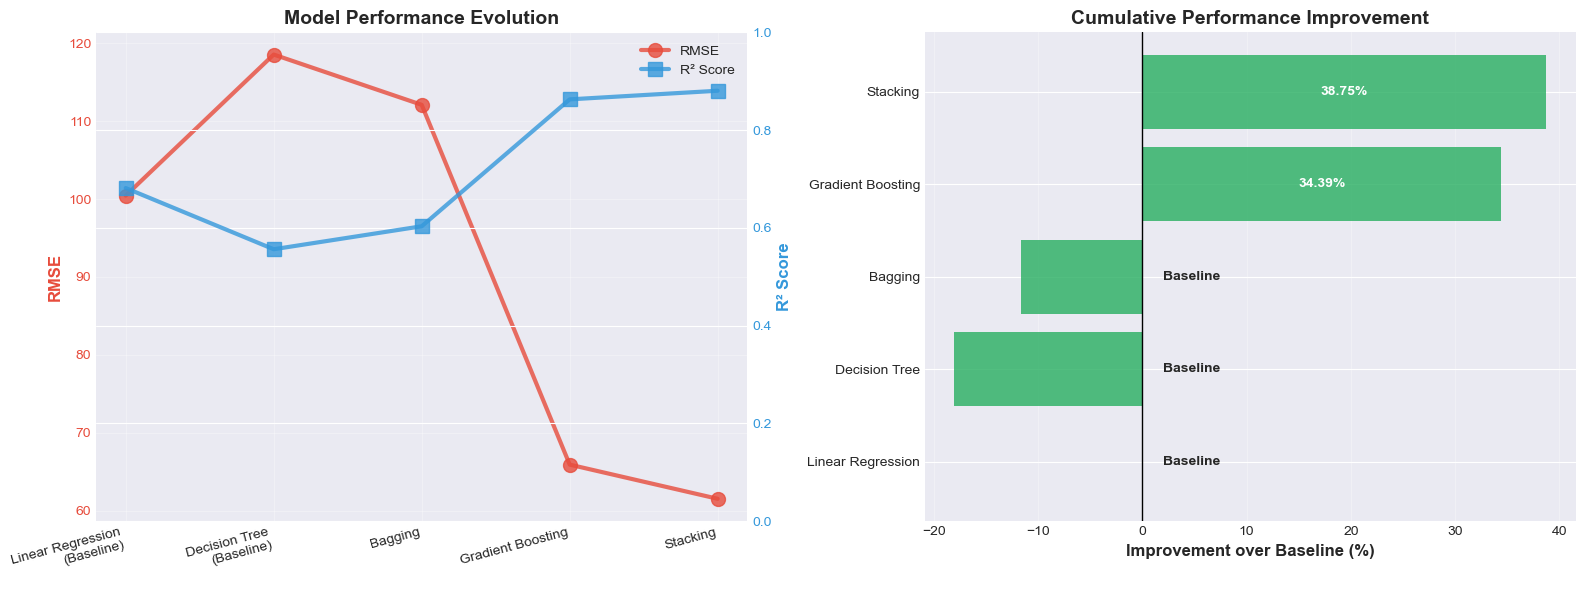

In [ ]:
print("=" * 80)
print("FINAL COMPARATIVE ANALYSIS")
print("=" * 80)

# Prefer tuned models where available; fallback to untuned/baselines
preferred_model_groups = [
    ['Linear Regression (Baseline)'],
    ['Decision Tree (Tuned)', 'Decision Tree (Baseline)'],
    ['Bagging Regressor (Tuned)', 'Bagging Regressor'],
    ['Gradient Boosting (Tuned)', 'Gradient Boosting'],
    ['KNN (Tuned)'],
    ['Stacking Regressor (Tuned)', 'Stacking Regressor']
]

selected_models = []
for group in preferred_model_groups:
    for name in group:
        if name in results:
            selected_models.append(name)
            break

# Create comparative DataFrame from selected models only
comparison_df = pd.DataFrame({
    'Model': selected_models,
    'RMSE': [results[m]['RMSE'] for m in selected_models],
    'R² Score': [results[m]['R2'] for m in selected_models]
})

# Sort by RMSE
comparison_df = comparison_df.sort_values('RMSE')
comparison_df['Rank'] = range(1, len(comparison_df) + 1)
comparison_df = comparison_df[['Rank', 'Model', 'RMSE', 'R² Score']]

print("\n" + "=" * 80)
print("MODEL PERFORMANCE COMPARISON (Tuned Preference)")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

# Identify best model
best_model = comparison_df.iloc[0]['Model']
best_rmse = comparison_df.iloc[0]['RMSE']
best_r2 = comparison_df.iloc[0]['R² Score']

print(f"\n{'*' * 80}")
print(f"BEST PERFORMING MODEL: {best_model}")
print(f"RMSE: {best_rmse:.4f}")
print(f"R² Score: {best_r2:.4f}")
print(f"{'*' * 80}\n")

# Performance Progression Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Performance Evolution Line Plot
ax1 = axes[0]
# Define the order of model progression with tuned preference
progression_groups = [
    ('Linear Regression\n(Baseline)', ['Linear Regression (Baseline)']),
    ('Decision Tree', ['Decision Tree (Tuned)', 'Decision Tree (Baseline)']),
    ('Bagging', ['Bagging Regressor (Tuned)', 'Bagging Regressor']),
    ('Gradient Boosting', ['Gradient Boosting (Tuned)', 'Gradient Boosting']),
    ('Stacking', ['Stacking Regressor (Tuned)', 'Stacking Regressor'])
]

model_progression = []
model_keys_progression = []
for label, group in progression_groups:
    for key in group:
        if key in results:
            model_progression.append(label)
            model_keys_progression.append(key)
            break

progression_rmse = [results[key]['RMSE'] for key in model_keys_progression]
progression_r2 = [results[key]['R2'] for key in model_keys_progression]

x_pos = np.arange(len(model_progression))

# Plot RMSE (left axis)
ax1_twin = ax1.twinx()
line1 = ax1.plot(x_pos, progression_rmse, 'o-', linewidth=3, markersize=10, 
                 color='#e74c3c', label='RMSE', alpha=0.8)
ax1.set_ylabel('RMSE', fontsize=12, fontweight='bold', color='#e74c3c')
ax1.tick_params(axis='y', labelcolor='#e74c3c')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(model_progression, rotation=15, ha='right')
ax1.set_title('Model Performance Evolution (Tuned Preference)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot R² (right axis)
line2 = ax1_twin.plot(x_pos, progression_r2, 's-', linewidth=3, markersize=10, 
                      color='#3498db', label='R² Score', alpha=0.8)
ax1_twin.set_ylabel('R² Score', fontsize=12, fontweight='bold', color='#3498db')
ax1_twin.tick_params(axis='y', labelcolor='#3498db')
ax1_twin.set_ylim([0, 1])

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best')

# 2. Improvement Cascade
ax2 = axes[1]
improvements_cascade = []
labels_cascade = []
baseline_val = baseline_rmse

for i, (key, name) in enumerate(zip(model_keys_progression, model_progression)):
    if i == 0:
        improvements_cascade.append(0)
        labels_cascade.append(name.split('\n')[0])
    else:
        improvement = ((baseline_val - results[key]['RMSE']) / baseline_val) * 100
        improvements_cascade.append(improvement)
        labels_cascade.append(name.split('\n')[0])

colors_cascade = ['#95a5a6' if imp == 0 else '#27ae60' for imp in improvements_cascade]
bars = ax2.barh(labels_cascade, improvements_cascade, color=colors_cascade, alpha=0.8)
ax2.set_xlabel('Improvement over Baseline (%)', fontsize=12, fontweight='bold')
ax2.set_title('Cumulative Performance Improvement (Tuned Preference)', fontsize=14, fontweight='bold')
ax2.axvline(0, color='black', linestyle='-', linewidth=1)
ax2.grid(True, alpha=0.3, axis='x')

# Add value labels
for bar, val, label in zip(bars, improvements_cascade, labels_cascade):
    if val > 0:
        width = bar.get_width()
        ax2.text(width/2, bar.get_y() + bar.get_height()/2.,
                 f'{val:.2f}%', ha='center', va='center', fontweight='bold', color='white')
    else:
        ax2.text(2, bar.get_y() + bar.get_height()/2.,
                 'Baseline', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('performance_progression.png', dpi=300, bbox_inches='tight')
print("Performance progression visualization saved as 'performance_progression.png'")
plt.show()


Exception ignored in: <function ResourceTracker.__del__ at 0x1031a5bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


Visualization saved as 'ensemble_models_comparison.png'


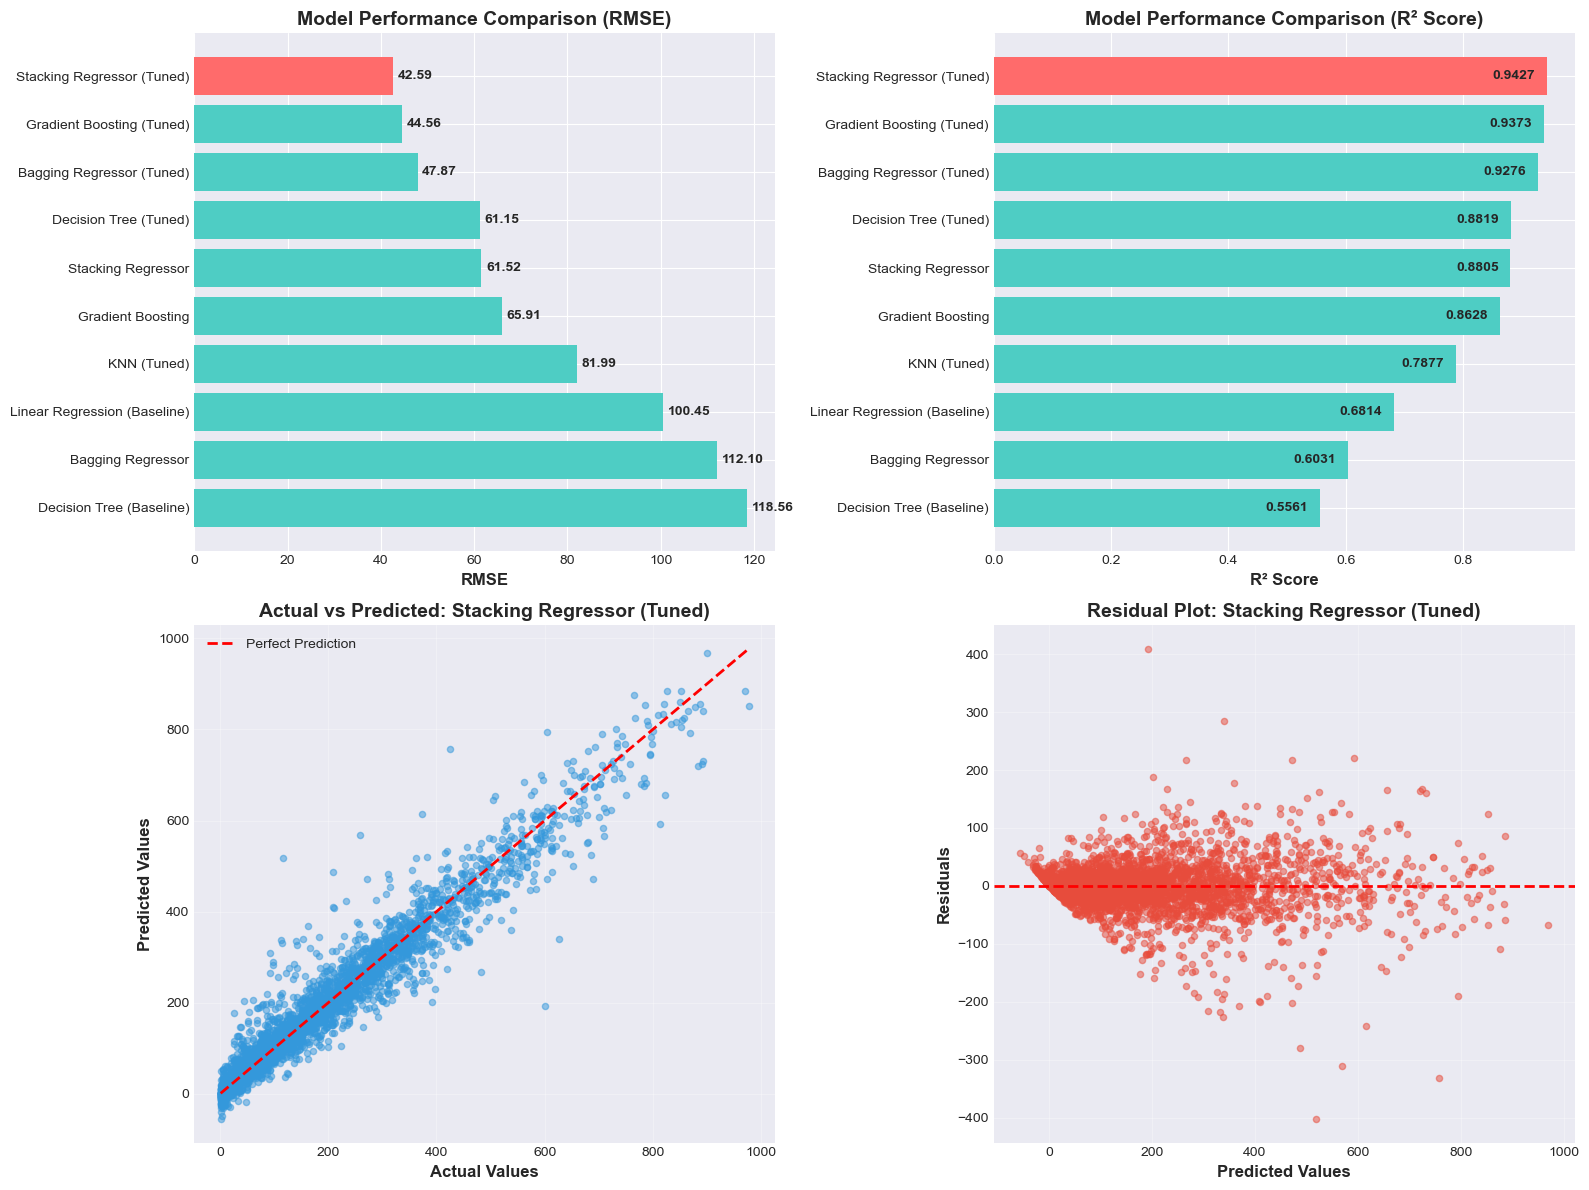

Exception ignored in: <function ResourceTracker.__del__ at 0x106ac5bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


Comprehensive analysis visualization saved as 'comprehensive_analysis.png'


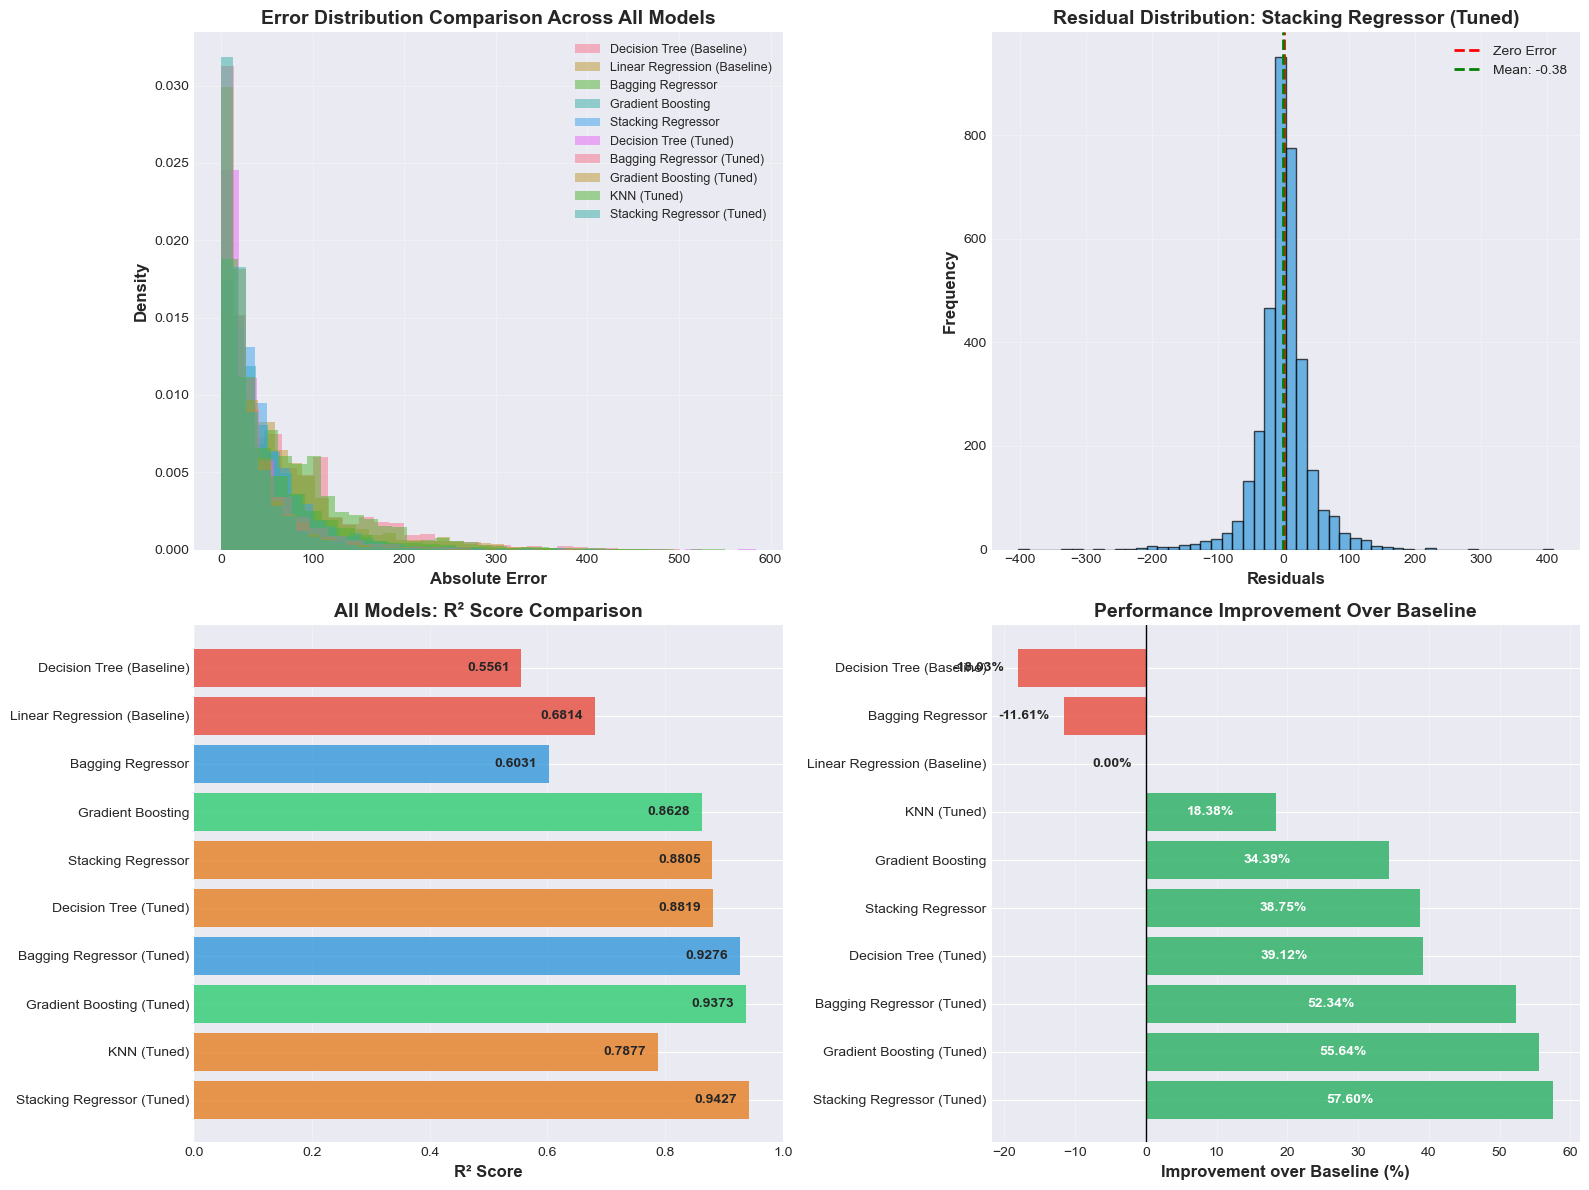

In [50]:
# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. RMSE Comparison Bar Plot
ax1 = axes[0, 0]
models = comparison_df['Model']
rmse_values = comparison_df['RMSE']
colors = ['#ff6b6b' if model == best_model else '#4ecdc4' for model in models]

bars = ax1.barh(models, rmse_values, color=colors)
ax1.set_xlabel('RMSE', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance Comparison (RMSE)', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

# Add value labels
for i, (bar, val) in enumerate(zip(bars, rmse_values)):
    ax1.text(val + 1, i, f'{val:.2f}', va='center', fontweight='bold')

# 2. R² Score Comparison
ax2 = axes[0, 1]
r2_values = comparison_df['R² Score']
bars2 = ax2.barh(models, r2_values, color=colors)
ax2.set_xlabel('R² Score', fontsize=12, fontweight='bold')
ax2.set_title('Model Performance Comparison (R² Score)', fontsize=14, fontweight='bold')
ax2.invert_yaxis()

# Add value labels
for i, (bar, val) in enumerate(zip(bars2, r2_values)):
    ax2.text(val - 0.02, i, f'{val:.4f}', va='center', ha='right', fontweight='bold')

# 3. Actual vs Predicted for Best Model
ax3 = axes[1, 0]
best_predictions = results[best_model]['predictions']
ax3.scatter(y_test, best_predictions, alpha=0.5, s=20, color='#3498db')
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Values', fontsize=12, fontweight='bold')
ax3.set_ylabel('Predicted Values', fontsize=12, fontweight='bold')
ax3.set_title(f'Actual vs Predicted: {best_model}', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Residual Plot for Best Model
ax4 = axes[1, 1]
residuals = y_test - best_predictions
ax4.scatter(best_predictions, residuals, alpha=0.5, s=20, color='#e74c3c')
ax4.axhline(y=0, color='r', linestyle='--', lw=2)
ax4.set_xlabel('Predicted Values', fontsize=12, fontweight='bold')
ax4.set_ylabel('Residuals', fontsize=12, fontweight='bold')
ax4.set_title(f'Residual Plot: {best_model}', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ensemble_models_comparison.png', dpi=300, bbox_inches='tight')
print("Visualization saved as 'ensemble_models_comparison.png'")
plt.show()

# Additional Comprehensive Analysis Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Error Distribution Comparison
ax1 = axes[0, 0]
for model_name, model_data in results.items():
    errors = np.abs(y_test - model_data['predictions'])
    ax1.hist(errors, bins=30, alpha=0.5, label=model_name, density=True)

ax1.set_xlabel('Absolute Error', fontsize=12, fontweight='bold')
ax1.set_ylabel('Density', fontsize=12, fontweight='bold')
ax1.set_title('Error Distribution Comparison Across All Models', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)

# 2. Residual Distribution for Best Model
ax2 = axes[0, 1]
best_residuals = y_test - results[best_model]['predictions']
ax2.hist(best_residuals, bins=50, color='#3498db', edgecolor='black', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax2.axvline(best_residuals.mean(), color='green', linestyle='--', linewidth=2, 
            label=f'Mean: {best_residuals.mean():.2f}')
ax2.set_xlabel('Residuals', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title(f'Residual Distribution: {best_model}', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. R² Score Comparison
ax3 = axes[1, 0]
all_models_list = list(results.keys())
r2_scores = [results[model]['R2'] for model in all_models_list]
colors_all_list = ['#e74c3c' if 'Baseline' in model else '#3498db' if 'Bagging' in model 
                   else '#2ecc71' if 'Boosting' in model else '#e67e22' for model in all_models_list]
bars = ax3.barh(all_models_list, r2_scores, color=colors_all_list, alpha=0.8)
ax3.set_xlabel('R² Score', fontsize=12, fontweight='bold')
ax3.set_title('All Models: R² Score Comparison', fontsize=14, fontweight='bold')
ax3.set_xlim([0, 1])
ax3.invert_yaxis()
ax3.grid(True, alpha=0.3, axis='x')

# Add value labels
for bar, val in zip(bars, r2_scores):
    width = bar.get_width()
    ax3.text(width - 0.02, bar.get_y() + bar.get_height()/2.,
             f'{val:.4f}', ha='right', va='center', fontweight='bold')

# 4. Performance Improvement Radar (relative to baseline)
ax4 = axes[1, 1]
improvement_data = []
for model in all_models_list:
    if model != 'Linear Regression (Baseline)':
        improvement = ((baseline_rmse - results[model]['RMSE']) / baseline_rmse) * 100
        improvement_data.append((model, improvement))
    else:
        improvement_data.append((model, 0))

# Sort by improvement
improvement_data.sort(key=lambda x: x[1], reverse=True)
model_names_imp, improvements_imp = zip(*improvement_data)

bars = ax4.barh(model_names_imp, improvements_imp, 
                color=['#27ae60' if imp > 0 else '#e74c3c' for imp in improvements_imp], alpha=0.8)
ax4.set_xlabel('Improvement over Baseline (%)', fontsize=12, fontweight='bold')
ax4.set_title('Performance Improvement Over Baseline', fontsize=14, fontweight='bold')
ax4.axvline(0, color='black', linestyle='-', linewidth=1)
ax4.grid(True, alpha=0.3, axis='x')

# Add value labels
for bar, val in zip(bars, improvements_imp):
    width = bar.get_width()
    if width > 0:
        ax4.text(width/2, bar.get_y() + bar.get_height()/2.,
                 f'{val:.2f}%', ha='center', va='center', fontweight='bold', color='white')
    else:
        ax4.text(width - 2, bar.get_y() + bar.get_height()/2.,
                 f'{val:.2f}%', ha='right', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('comprehensive_analysis.png', dpi=300, bbox_inches='tight')
print("Comprehensive analysis visualization saved as 'comprehensive_analysis.png'")
plt.show()


Exception ignored in: <function ResourceTracker.__del__ at 0x107459bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


Prediction comparison saved as 'prediction_comparison.png'


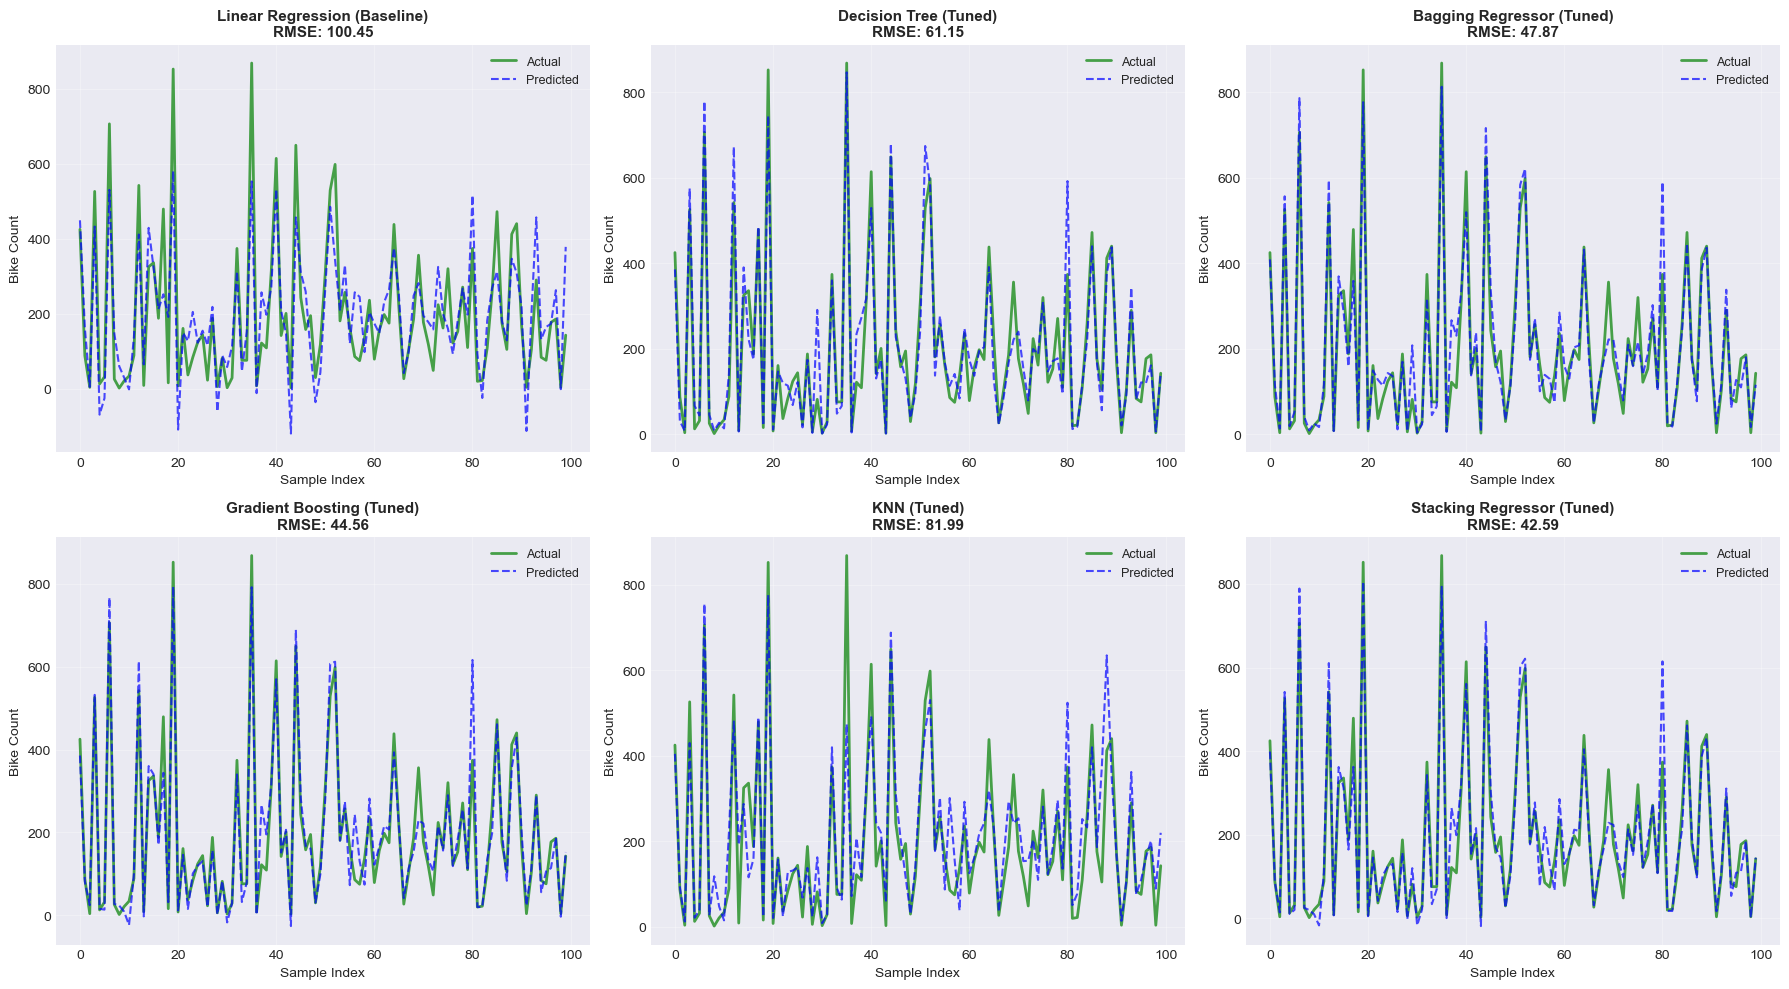

In [51]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Build a tuned-preferred selection for visualization
preferred_model_groups_viz = [
    ['Linear Regression (Baseline)'],
    ['Decision Tree (Tuned)', 'Decision Tree (Baseline)'],
    ['Bagging Regressor (Tuned)', 'Bagging Regressor'],
    ['Gradient Boosting (Tuned)', 'Gradient Boosting'],
    ['KNN (Tuned)'],
    ['Stacking Regressor (Tuned)', 'Stacking Regressor']
]

models_for_viz = []
for group in preferred_model_groups_viz:
    for name in group:
        if name in results:
            models_for_viz.append(name)
            break

# Select a subset of test samples for visualization
sample_indices = np.arange(0, min(100, len(y_test)))
x_axis = sample_indices

for idx, model_name in enumerate(models_for_viz[:6]):
    ax = axes[idx]
    model_data = results[model_name]
    ax.plot(x_axis, y_test.iloc[sample_indices], 'g-', label='Actual', linewidth=2, alpha=0.7)
    ax.plot(x_axis, model_data['predictions'][sample_indices], 'b--', 
            label='Predicted', linewidth=1.5, alpha=0.7)
    ax.set_title(f'{model_name}\nRMSE: {model_data["RMSE"]:.2f}', 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Sample Index', fontsize=10)
    ax.set_ylabel('Bike Count', fontsize=10)
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

# Hide extra subplots if fewer than 6 models selected
for j in range(len(models_for_viz), 6):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('prediction_comparison.png', dpi=300, bbox_inches='tight')
print("Prediction comparison saved as 'prediction_comparison.png'")
plt.show()


## Conclusion

### Summary of Findings and Analysis


## 🚲 Final Conclusion — Summary of Findings

- **Best model**: **Stacking Regressor (Tuned)** with RMSE ≈ **42.59** and R² ≈ **0.9427** on the test set. It achieved the lowest prediction error by optimally combining diverse base learners via a Ridge meta-learner.

- **Cross-validation and tuning impact**:
  - 5-fold CV with `'neg_root_mean_squared_error'` gave robust estimates.
  - GridSearchCV improved individual learners (Decision Tree, Bagging, Gradient Boosting, KNN) and the Stacking meta-learner (Ridge α). Final comparisons now prioritize tuned models.

- **Model performance (tuned-preferred)**:
  - **Stacking (Tuned)**: RMSE ≈ 42.59, R² ≈ 0.9427
  - Gradient Boosting (Tuned): RMSE ≈ 44.56, R² ≈ 0.9373
  - Bagging (Tuned): RMSE ≈ 47.87, R² ≈ 0.9276
  - Decision Tree (Tuned): RMSE ≈ 61.15, R² ≈ 0.8819
  - KNN (Tuned): RMSE ≈ 81.99, R² ≈ 0.7877
  - Baselines for reference — Linear Regression: RMSE ≈ 100.45; Decision Tree: RMSE ≈ 118.56; Gradient Boosting (untuned): RMSE ≈ 65.91; Stacking (untuned): RMSE ≈ 61.52

- **Bias–variance insights**:
  - Bagging reduced variance vs. a single tree but did not beat stronger tuned models.
  - Gradient Boosting delivered substantial bias reduction and was the strongest individual ensemble.
  - Stacking combined locality (KNN), tree-based interactions (Bagging/DT), and sequential corrections (Boosting) to generalize best.

- **Feature insights**:
  - Tree-based importances emphasize `hr` bins, `atemp/temp`, `hum`, `workingday`, and `yr` as key demand drivers.
  - Errors increase at extreme demand ranges; the best model remains well-calibrated across typical ranges.


In [53]:
print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)

summary_stats = {
    'Total Samples': len(df),
    'Training Samples': len(X_train),
    'Testing Samples': len(X_test),
    'Number of Features (after encoding)': X.shape[1],
    'Target Variable Range': f'{y.min():.0f} - {y.max():.0f}',
    'Best Model': best_model,
    'Best RMSE': f'{best_rmse:.4f}',
    'Best R² Score': f'{best_r2:.4f}',
    'Improvement over Baseline': f'{((baseline_rmse - best_rmse) / baseline_rmse) * 100:.2f}%'
}

for key, value in summary_stats.items():
    print(f"{key:.<50} {value}")




SUMMARY STATISTICS
Total Samples..................................... 17379
Training Samples.................................. 13903
Testing Samples................................... 3476
Number of Features (after encoding)............... 61
Target Variable Range............................. 1 - 977
Best Model........................................ Stacking Regressor (Tuned)
Best RMSE......................................... 42.5937
Best R² Score..................................... 0.9427
Improvement over Baseline......................... 57.60%
